Erro Médio Absoluto no Teste: 0.19840810926059518
R² score: 0.4631540396216297
Desvio padrão dos resíduos no teste: 0.25460689908121986


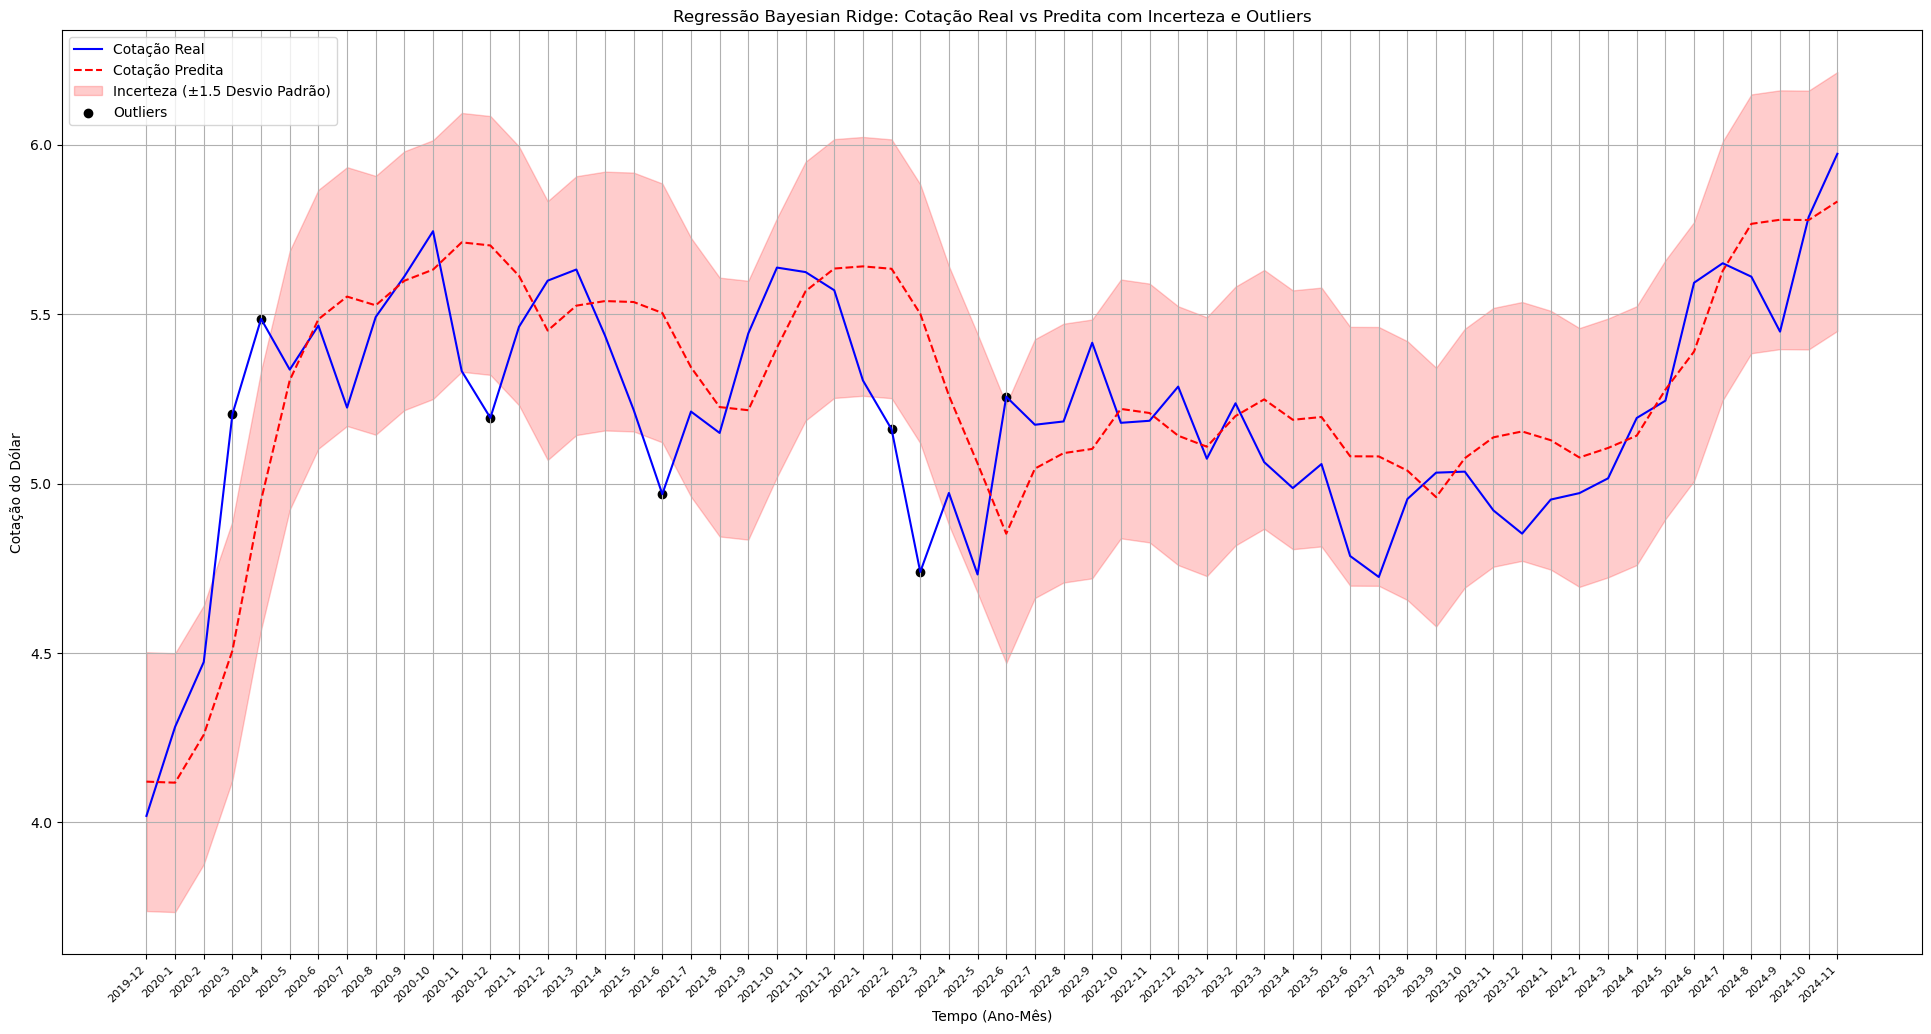

In [5]:
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Carregar os dados
file_path = "Dataset_Dolar.csv"
df = pd.read_csv(file_path)
df = df[['t', 'ano', 'mes', 'cotacao', 'ipca_acumulado', 'cpi', 'selic',
       'divida_pp', 'fed_rate']]
# Criar novas features (médias móveis e desvio padrão)
for column in ['cotacao', 'selic',
       'divida_pp', 'fed_rate']:
    mean_name = column + '_mean'
    std_name = column + '_std'
    df[mean_name] = df[column].shift(1).rolling(window=3, min_periods=1).mean()
    df.fillna(df[column].values[0], inplace=True)  # Lidar com NaNs no início

    
    df[std_name] = df[column].shift(1).rolling(window=3, min_periods=1).std()
    df.fillna(0, inplace=True)  # Lidar com NaNs no início

# Definir variáveis preditoras e alvo
X = df.drop(columns=['cotacao', 't', 'ano', 'mes'])  # Remover colunas irrelevantes
y = df['cotacao']

# Separar treino e teste preservando a ordem temporal (80% treino, 20% teste)
train_size = int(len(df) * 0.80)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Normalizar os dados com MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Definir o modelo Bayesian Ridge
bayesian_ridge = BayesianRidge()

# Treinamento do modelo
bayesian_ridge.fit(X_train_scaled, y_train)

# Previsões para o conjunto de teste
y_test_pred = bayesian_ridge.predict(X_test_scaled)

# Calcular erro médio absoluto e R²
mae = mean_absolute_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)
print("Erro Médio Absoluto no Teste:", mae)
print("R² score:", r2)

# Calcular os resíduos (erro) no conjunto de teste
residuos_test = y_test - y_test_pred
std_dev = np.std(residuos_test)

print(f"Desvio padrão dos resíduos no teste: {std_dev}")

# Definir o fator de multiplicação para a faixa de incerteza
mul_std = 1.5

# Identificar pontos que estão fora da faixa de incerteza
lower_bound = y_test_pred - mul_std * std_dev
upper_bound = y_test_pred + mul_std * std_dev
outliers_mask = (y_test.values < lower_bound) | (y_test.values > upper_bound)

# Criar rótulos do eixo X (ano-mês) para o conjunto de teste
x_labels = df.iloc[train_size:][['ano', 'mes']].astype(str).agg('-'.join, axis=1).values

# Criar gráfico de predição vs. real
plt.figure(figsize=(24, 12))
plt.plot(x_labels, y_test.values, label="Cotação Real", color="blue")
plt.plot(x_labels, y_test_pred, label="Cotação Predita", color="red", linestyle="dashed")

# Adicionar faixa de incerteza
plt.fill_between(x_labels, lower_bound, upper_bound, 
                 color='red', alpha=0.2, label=f"Incerteza (±{mul_std} Desvio Padrão)")

# Plotar os outliers como pontos destacados
plt.scatter(np.array(x_labels)[outliers_mask], y_test.values[outliers_mask], 
            color='black', marker='o', label="Outliers")

# Melhorar legibilidade do eixo X
plt.xticks(rotation=45, ha='right', fontsize=8)

# Configurações do gráfico
plt.xlabel("Tempo (Ano-Mês)")
plt.ylabel("Cotação do Dólar")
plt.title("Regressão Bayesian Ridge: Cotação Real vs Predita com Incerteza e Outliers")
plt.legend()
plt.grid()
plt.show()


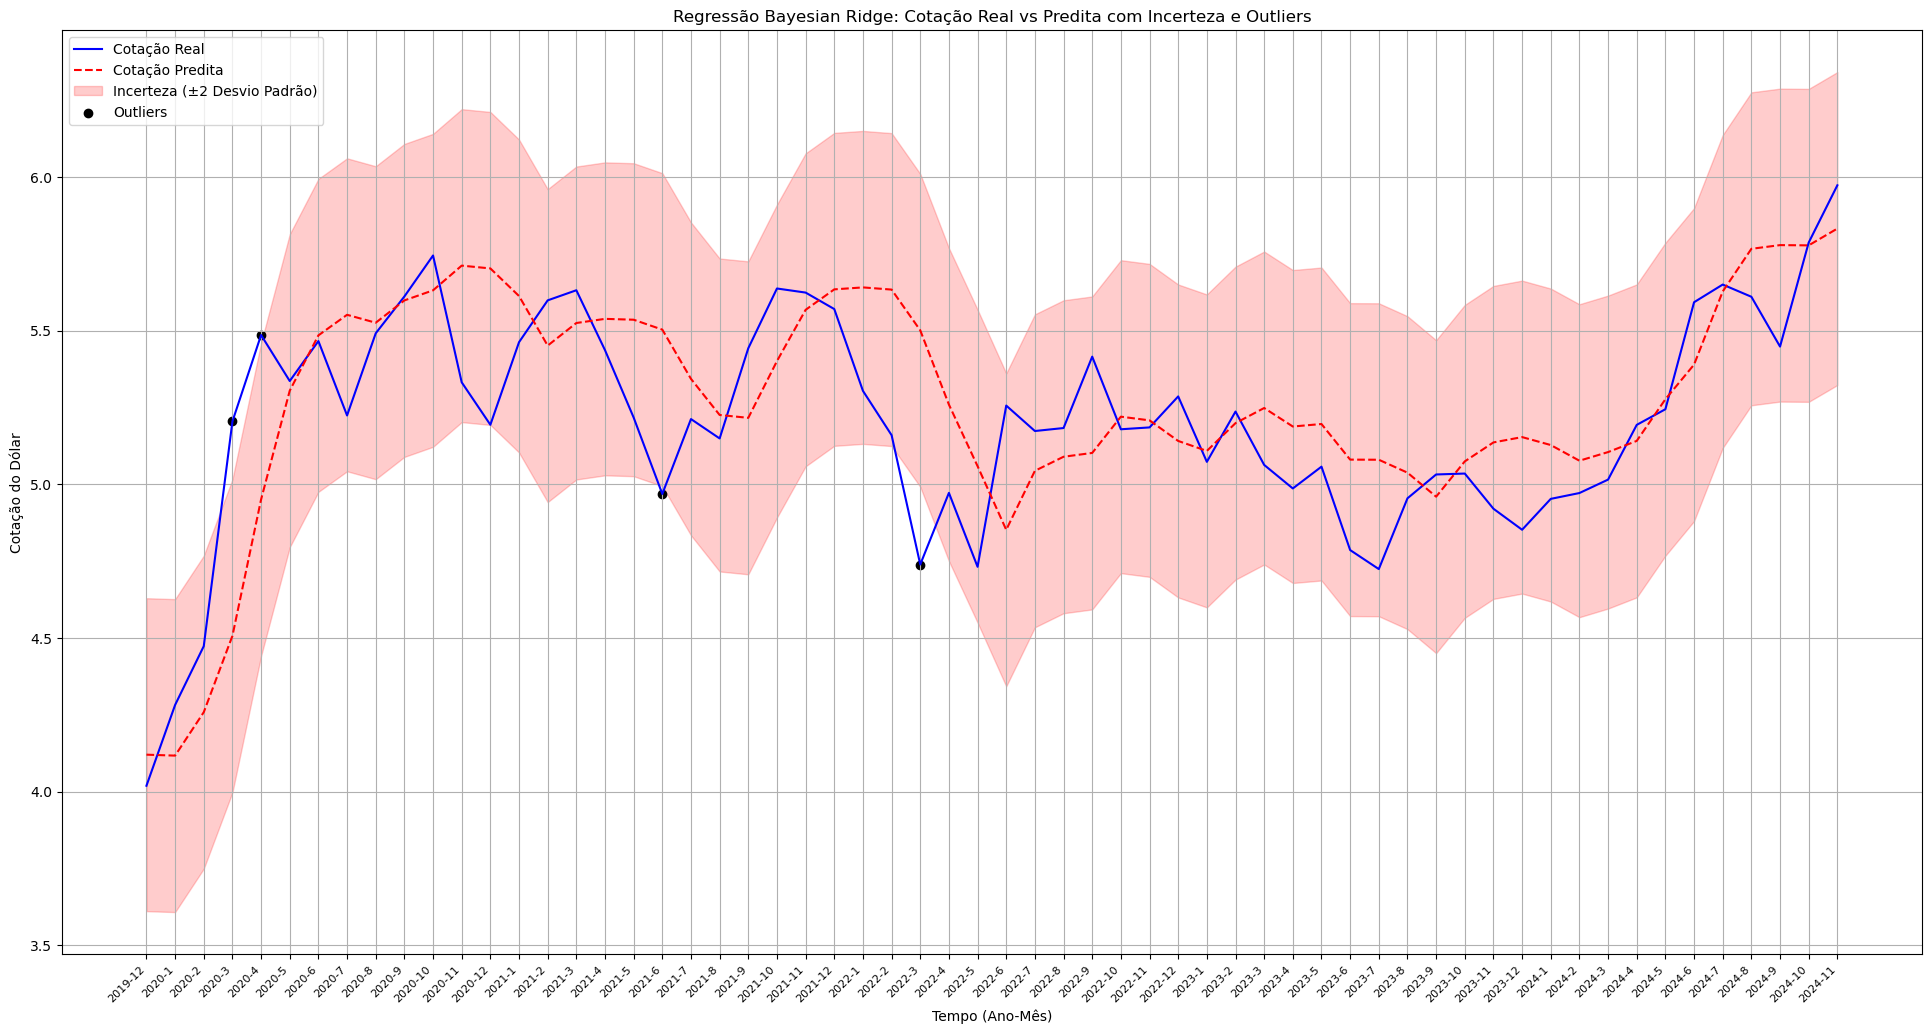

In [6]:
# Definir o fator de multiplicação para a faixa de incerteza
mul_std = 2

# Identificar pontos que estão fora da faixa de incerteza
lower_bound = y_test_pred - mul_std * std_dev
upper_bound = y_test_pred + mul_std * std_dev
outliers_mask = (y_test.values < lower_bound) | (y_test.values > upper_bound)

# Criar rótulos do eixo X (ano-mês) para o conjunto de teste
x_labels = df.iloc[train_size:][['ano', 'mes']].astype(str).agg('-'.join, axis=1).values

# Criar gráfico de predição vs. real
plt.figure(figsize=(24, 12))
plt.plot(x_labels, y_test.values, label="Cotação Real", color="blue")
plt.plot(x_labels, y_test_pred, label="Cotação Predita", color="red", linestyle="dashed")

# Adicionar faixa de incerteza
plt.fill_between(x_labels, lower_bound, upper_bound, 
                 color='red', alpha=0.2, label=f"Incerteza (±{mul_std} Desvio Padrão)")

# Plotar os outliers como pontos destacados
plt.scatter(np.array(x_labels)[outliers_mask], y_test.values[outliers_mask], 
            color='black', marker='o', label="Outliers")

# Melhorar legibilidade do eixo X
plt.xticks(rotation=45, ha='right', fontsize=8)

# Configurações do gráfico
plt.xlabel("Tempo (Ano-Mês)")
plt.ylabel("Cotação do Dólar")
plt.title("Regressão Bayesian Ridge: Cotação Real vs Predita com Incerteza e Outliers")
plt.legend()
plt.grid()
plt.show()